In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot
from historymatch import utils


# import external modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import pickle
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 18})

np.random.seed(4)

In [2]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses_single = Masses.groupby('A').apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A0_single = Masses_single['A'].to_numpy()
Z0_single = Masses_single['Z'].to_numpy()
N0_single = Masses_single['N'].to_numpy()
Element_single = Masses_single['Element'].to_numpy()

# convert energies per nucleon to energies
Energies0_single = Masses_single['Ebinding'].to_numpy()

Energies_unc0_single = Masses_single['E_unc'].to_numpy()

# extract 3 nucleon around maximum
Masses_triple = Masses.sort_values(['A','Ebinding'],ascending=False).groupby('A').head(3)

A0_triple = Masses_triple['A'].to_numpy()
Z0_triple = Masses_triple['Z'].to_numpy()
N0_triple = Masses_triple['N'].to_numpy()
Element_triple = Masses_triple['Element'].to_numpy()

# convert energies per nucleon to energies
Energies0_triple = Masses_triple['Ebinding'].to_numpy()

Energies_unc0_triple = Masses_triple['E_unc'].to_numpy()

In [3]:
# define parameter space

theta_0_bound = np.array([-10, 40]).reshape(1,-1)
theta_1_bound = np.array([-40, 10]).reshape(1,-1)
theta_2_bound = np.array([-3, 3]).reshape(1,-1)
theta_3_bound = np.array([-50, 0]).reshape(1,-1) # keep
theta_4_bound = np.array([0, 40]).reshape(1,-1)

parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound, theta_3_bound, theta_4_bound), axis=0)


In [4]:
def LiquidDropModel(params, A, Z, N):
    
    if len(params) == 4:
        a1, a2, a3, a4 = params
        EB = (a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
            + a4*((N-Z)**2)/A)
        return EB/A
    else:
        a1, a2, a3, a4, a5 = params
        EB = (a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
            + a4*((N-Z)**2)/A + a5*( (-1)**Z + (-1)**N )*(2*A**(-0.5)))
        return EB/A
    

In [5]:
def create_model_error(_A):
    
    sigma_model = np.zeros(len(_A))     
        
    for i in range(len(_A)):
        if _A[i] < 40:
            sigma_model[i] = 0.09


        elif _A[i] < 140:
            sigma_model[i] = 0.05

        elif _A[i] < 200:
            sigma_model[i] = 0.04
        else:
            sigma_model[i] = 0.02
            
    return sigma_model


In [6]:
# define observational data for each wave

# wave 1 - A < 40
obs_data_wave1 = Energies0_single[10:30:2]
A_wave1 = A0_single[10:30:2]
Z_wave1 = Z0_single[10:30:2]
N_wave1 = N0_single[10:30:2]
variables_wave1 = np.concatenate((A_wave1.reshape(-1,1),Z_wave1.reshape(-1,1),\
                            N_wave1.reshape(-1,1)), axis=1)

sigma_obs_wave1 = Energies_unc0_single[10:30:2]
sigma_model_wave1 = create_model_error(A_wave1)


# wave 2 - A < 140
obs_data_wave2 = Energies0_single[10:130:3]
A_wave2 = A0_single[10:130:3]
Z_wave2 = Z0_single[10:130:3]
N_wave2 = N0_single[10:130:3]
variables_wave2 = np.concatenate((A_wave2.reshape(-1,1),Z_wave2.reshape(-1,1),\
                            N_wave2.reshape(-1,1)), axis=1)

sigma_obs_wave2 = Energies_unc0_single[10:130:3]
sigma_model_wave2 = create_model_error(A_wave2)


# wave 3 - A < 200
obs_data_wave3 = Energies0_single[10:190:3]
A_wave3 = A0_single[10:190:3]
Z_wave3 = Z0_single[10:190:3]
N_wave3 = N0_single[10:190:3]
variables_wave3 = np.concatenate((A_wave3.reshape(-1,1),Z_wave3.reshape(-1,1),\
                            N_wave3.reshape(-1,1)), axis=1)

sigma_obs_wave3 = Energies_unc0_single[10:190:3]
sigma_model_wave3 = create_model_error(A_wave3)


# wave 4 - A > 200
obs_data_wave4 = Energies0_single[10:-1:3]
A_wave4 = A0_single[10:-1:3]
Z_wave4 = Z0_single[10:-1:3]
N_wave4 = N0_single[10:-1:3]
variables_wave4 = np.concatenate((A_wave4.reshape(-1,1),Z_wave4.reshape(-1,1),\
                            N_wave4.reshape(-1,1)), axis=1)

sigma_obs_wave4 = Energies_unc0_single[10:-1:3]
sigma_model_wave4 = create_model_error(A_wave4)


# wave 5 - introduce ap - all data such that 3 points around E minimum are captured
obs_data_wave5 = np.flip(Energies0_triple)[30:-1:4]
A_wave5 = np.flip(A0_triple)[30:-1:4]
Z_wave5 = np.flip(Z0_triple)[30:-1:4]
N_wave5 = np.flip(N0_triple)[30:-1:4]
variables_wave5 = np.concatenate((A_wave5.reshape(-1,1),Z_wave5.reshape(-1,1),\
                            N_wave5.reshape(-1,1)), axis=1)

sigma_obs_wave5 = np.flip(Energies_unc0_triple)[30:-1:4]
sigma_model_wave5 = create_model_error(A_wave5)


obs_data = [obs_data_wave1, obs_data_wave2, obs_data_wave3, obs_data_wave4, obs_data_wave5, obs_data_wave5]
sigma_obs = [sigma_obs_wave1, sigma_obs_wave2, sigma_obs_wave3, sigma_obs_wave4, sigma_obs_wave5, sigma_obs_wave5]
sigma_model = [sigma_model_wave1, sigma_model_wave2, sigma_model_wave3, sigma_model_wave4, sigma_model_wave5, sigma_model_wave5]

variables = [variables_wave1, variables_wave2, variables_wave3, variables_wave4, variables_wave5, variables_wave5]

sigma_method = [np.zeros_like(sigmas) for sigmas in sigma_model]

# History Matching - Initialise

In [7]:
volshapes = ['gaussian', 'hypercube', 'hypercube_rot', 'ellipsoid']

In [8]:
nwaves = 3
ndim = 5
nsamples = 1 * (10**6)
volshape = 'gaussian'
filename = 'HM_results'

In [9]:
# initialise history matching class
HM = historymatch.HistoryMatch(ndim, filename=filename, emulator='GP', volume_shape=volshape)
# initialise results class
Results = historymatch.Results(filename)

In [10]:


ToyModel = historymatch.Simulator(HM)
ToyModel.set_simulator(LiquidDropModel)

HM.initialize_volume(parameter_bounds[:,0], parameter_bounds[:,1], ninactive=1, inactive_wave = 5, sigma_inactive=0.02)


# History Match - Separate Waves

The waves of history matching can be run separately. Uncomment the following code to do so.

In [11]:

#results_wave1 = HM.run_wave(1, obs_data[0], sigma_obs[0], sigma_model[0], sigma_method[0], variables[0], nsamples=nsamples, ntraining=100)

#HM.store_result(Results, wave=1, wave_results = results_wave1)

In [12]:
#results_wave2 = HM.run_wave(1, obs_data[1], sigma_obs[1], sigma_model[1], sigma_method[1], variables[1], nsamples=nsamples, ntraining=100)

#HM.store_result(Results, wave=2, wave_results = results_wave2)

# History Match - All Waves At Once

In [13]:
# initialise all observational data and run multiple waves
HM.set_observations(obs_data, variables=variables, sigma_obs=sigma_obs, sigma_model=sigma_model, sigma_method=sigma_method)

results = HM.run(nwaves=nwaves, ntraining=8, nsamples=nsamples, result_obj=Results, emulate=False, Imax1=None, Imax2=2.5)


Running wave 1


100%|███████████████████████████████████████████| 10/10 [00:14<00:00,  1.47s/it]


Number of Non-Implausible Samples: 317
Running wave 2


100%|███████████████████████████████████████████| 40/40 [00:59<00:00,  1.48s/it]


Number of Non-Implausible Samples: 18120
Running wave 3


100%|███████████████████████████████████████████| 60/60 [01:28<00:00,  1.47s/it]


Number of Non-Implausible Samples: 406161


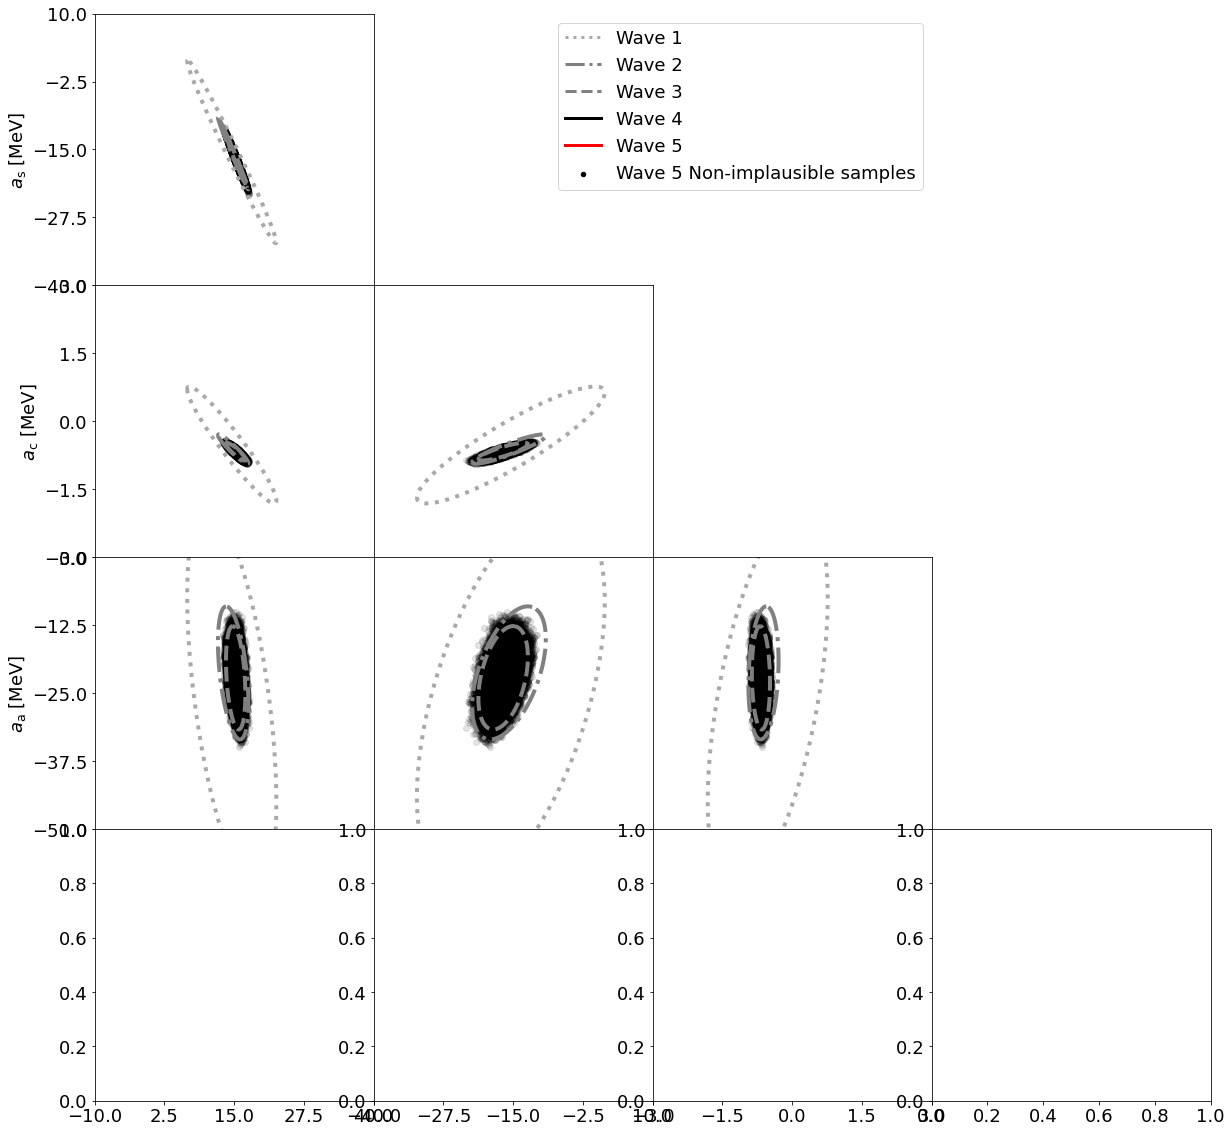

In [14]:
# plot corner plot of gaussian wave progression

colors = ['darkgrey', 'grey', 'grey', 'black', 'red']
linestyles = [':', '-.', '--','-','-', '']
theta_names = [r'$a_{\mathrm{v}}$ [MeV]', r'$a_{\mathrm{s}}$ [MeV]', r'$a_{\mathrm{c}}$ [MeV]', r'$a_{\mathrm{a}}$ [MeV]', r'$a_{\mathrm{p}}$ [MeV]']
dec_list = [0,0,0,0,0,0]

fig, axes = plt.subplots(ndim, ndim-1, figsize=(20,25), sharex='col')

for k in range(nwaves):
    
    # find mean and covariance of nonimplausible region
    nonimplausible = Results.nonimplausible[k]
    historymatch_cov = np.cov(nonimplausible[:,:-1].T)
    historymatch_mean = np.mean(nonimplausible[:,:-1], axis=0)
    
    if k < 4:
        dims = 4
    else:
        dims = 5
    
    # plot ellipses for each dimension
    for i in range(dims-1):
        for j in range(dims):
            ax = axes[j,i]
            
            if i != 0:
                ax.axes.yaxis.set_visible(False)
                
            if i < j:
                
                    
                param_cov = np.array([[historymatch_cov[i,i], historymatch_cov[i,j]],[historymatch_cov[j,i], historymatch_cov[j,j]]])
                param_mean = [historymatch_mean[i],historymatch_mean[j]]

                plot.get_cov_ellipse(param_cov, param_mean, 5.991, ax, colors[k], linestyles[k], lw=4)
                    
                ax.set_xlabel(theta_names[i])
                ax.set_ylabel(theta_names[j])
                
                if k==nwaves-1:
                    ax.scatter(results.nonimplausible[-1][:,i][0:-1:10], results.nonimplausible[-1][:,j][0:-1:10], alpha=0.1, color='black')
                
                # set limits to correspond to starting range
                ax.set_xlim([parameter_bounds[i,0],parameter_bounds[i,1]])
                ax.set_ylim([parameter_bounds[j,0],parameter_bounds[j,1]])

                ax.set_xticks(np.linspace(parameter_bounds[i,0], parameter_bounds[i,1], 5))
                ax.set_yticks(np.linspace(parameter_bounds[j,0], parameter_bounds[j,1], 5))

            elif j == 1:
                if i == 2:
                    pts = ax.scatter(100,100,color='black', s=20)
                    lines = [Line2D([0], [0], color=colors[c], linewidth=3, linestyle=linestyles[c]) for c in range(len(colors))]
                    lines.append(pts)
                    labels = ['Wave 1', 'Wave 2', 'Wave 3', 'Wave 4', 'Wave 5', 'Wave 5 Non-implausible samples']
                    ax.legend(lines, labels, loc='upper right')
                    ax.axis('off') 
                else:
                    ax.axis('off')    
            else:
                ax.axis('off')
                
for ax in axes[0, :]:
    fig.delaxes(ax)
    
fig.delaxes(axes[1,-1])
fig.delaxes(axes[2,-1])
fig.delaxes(axes[3,-1])       

fig.subplots_adjust(wspace=0, hspace=0)



# Save Results

In [15]:
# results are automatically saved to a pickle file. The code below saves results manually to a text file if preferred.

'''
shape = volshape
for wave in range(nwaves):
    file = open("data/w{}_{}_nonimp.txt".format(wave+1,shape), "w")
    np.savetxt(file, results.nonimplausible[wave])
    file.close()
    file3 = open("data/w{}_{}_samples.txt".format(wave+1,shape), "w")
    np.savetxt(file3, results.I_samples[wave])
    file3.close()
file2 = open("data/details_{}.txt".format(shape), "w")
np.savetxt(file2, keys, fmt="%s")
np.savetxt(file2, vals, fmt="%d")
file2.close()'''

'\nshape = volshape\nfor wave in range(nwaves):\n    file = open("data/w{}_{}_nonimp.txt".format(wave+1,shape), "w")\n    np.savetxt(file, results.nonimplausible[wave])\n    file.close()\n    file3 = open("data/w{}_{}_samples.txt".format(wave+1,shape), "w")\n    np.savetxt(file3, results.I_samples[wave])\n    file3.close()\nfile2 = open("data/details_{}.txt".format(shape), "w")\nnp.savetxt(file2, keys, fmt="%s")\nnp.savetxt(file2, vals, fmt="%d")\nfile2.close()'